In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


%matplotlib inline

In [2]:
HOUSING_PATH = 'data'

In [3]:
def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [4]:
data = load_housing_data(HOUSING_PATH)
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


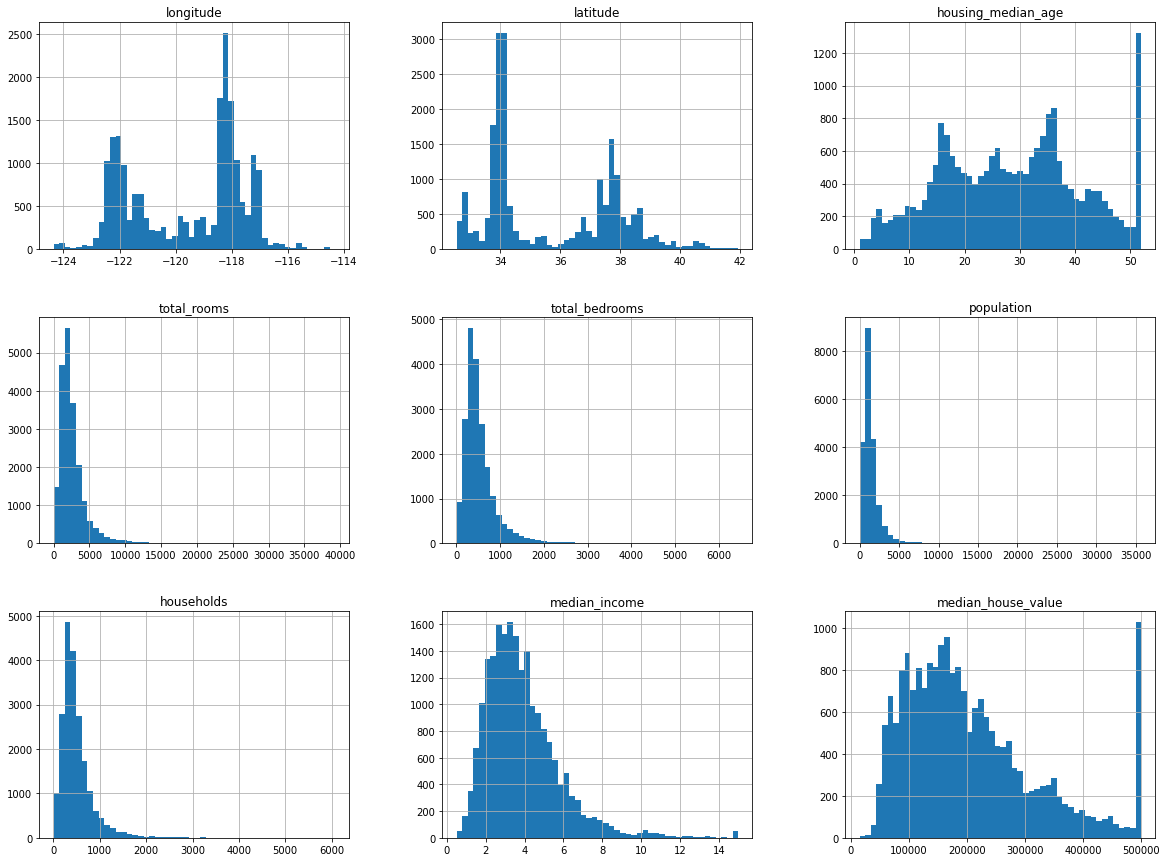

In [7]:
data.hist(bins=50, figsize=(20,15))
plt.show()

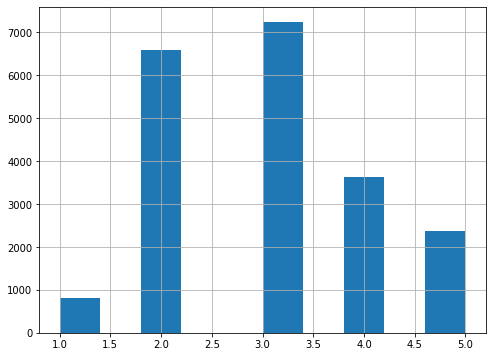

In [8]:
data['median_income_cat'] = pd.cut(data['median_income'], 
                                   bins=[0, 1.5, 3, 4.5, 6, np.inf],
                                   labels=[1, 2, 3, 4, 5])

data['median_income_cat'].hist(figsize=(8, 6))
plt.show()

In [9]:
train_set, test_set = train_test_split(data, test_size=.2, random_state=42)

In [10]:
splits = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)

for train_index, test_index in splits.split(data, data['median_income_cat']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [11]:
random_stratified = pd.DataFrame({
    'original': data['median_income_cat'].value_counts() / len(data),
    'stratified': strat_test_set['median_income_cat'].value_counts() / len(strat_test_set),
    'randomized': test_set['median_income_cat'].value_counts() / len(test_set)
})

In [12]:
random_stratified

,original,stratified,randomized
3,0.350581,0.350533,0.358527
2,0.318847,0.318798,0.324370
4,0.176308,0.176357,0.167393
5,0.114438,0.114341,0.109496
1,0.039826,0.039971,0.040213


In [13]:
for set_ in strat_train_set, strat_test_set:
    set_.drop('median_income_cat', axis=1, inplace=True)

# Visualizando

In [14]:
housing = strat_train_set.copy()

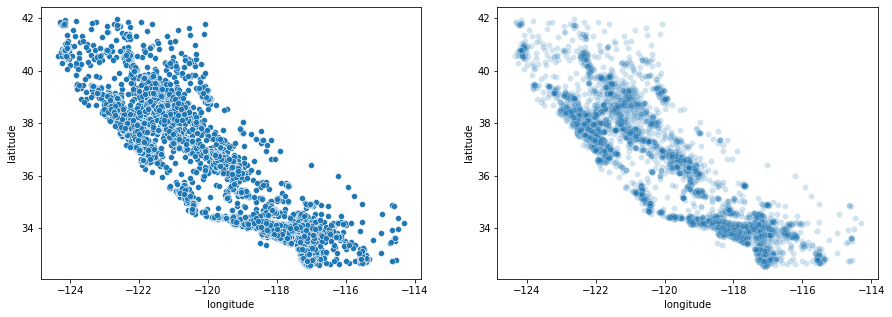

In [15]:
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.scatterplot(data=housing, x='longitude', y='latitude', alpha=1.0, ax=ax_1)
sns.scatterplot(data=housing, x='longitude', y='latitude', alpha=0.2, ax=ax_2)
plt.show()

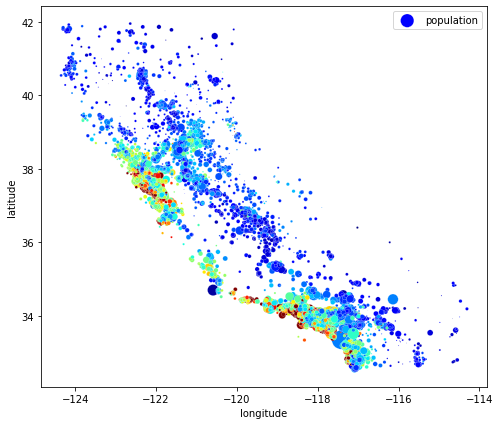

In [16]:
plt.figure(figsize=(8,7))
m = sns.scatterplot(data=housing, x='longitude', y='latitude', s=housing["population"]/100, 
                label="population", c=housing['median_house_value'], cmap=plt.get_cmap("jet"))

plt.show()

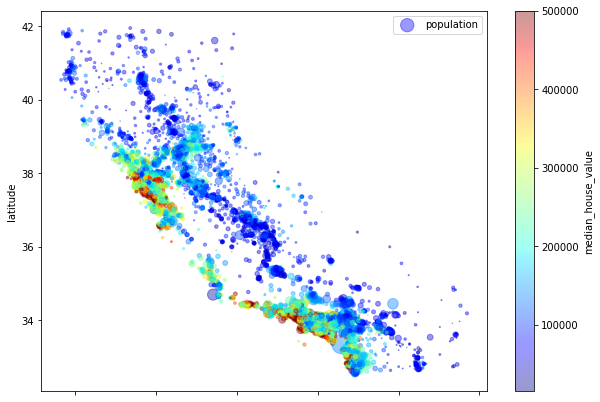

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

In [18]:
correlation_matrix = housing.corr()
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

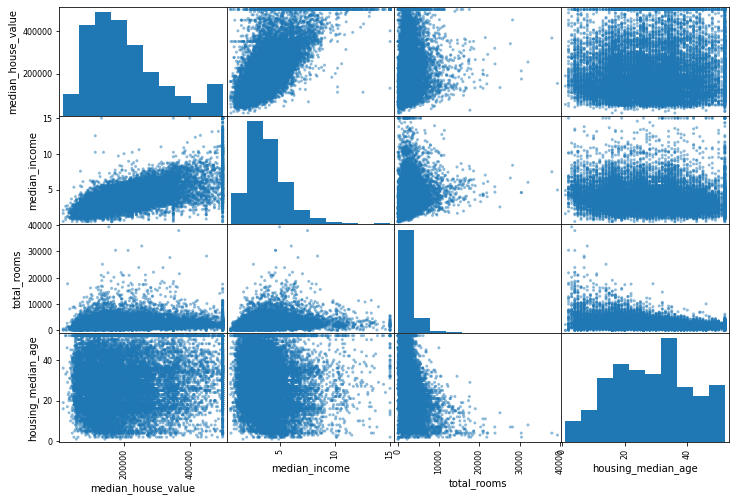

In [19]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

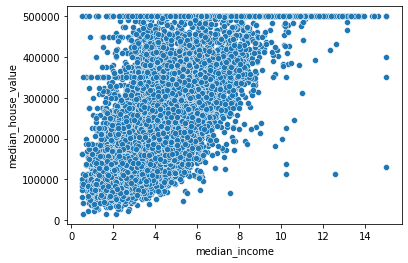

In [20]:
sns.scatterplot(data=housing, x='median_income', y='median_house_value')
plt.show()

In [21]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [22]:
correlation_matrix = housing.corr()
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Preparing the data

In [23]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data cleaning


In [24]:
imputer = SimpleImputer(strategy='median')

In [25]:
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)

housing_cl = pd.DataFrame(X, columns=housing_num.columns)
housing_cl.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [26]:
housing_cat = housing[['ocean_proximity']]
housing_cat = pd.get_dummies(housing_cat)
housing_cat.columns = [c.split('_')[-1] for c in housing_cat.columns]
housing_cat.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,0,1,0,0,0
15502,0,0,0,0,1
2908,0,1,0,0,0
14053,0,0,0,0,1
20496,1,0,0,0,0


## Custom transformer

In [27]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [28]:
rooms_colpos, bedrooms_colpos, population_colpos, households_colpos = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
        
    def __init__(self, add_bedrooms_per_room=False):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.columns_ = None
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_colpos] / X[:, households_colpos]
        population_per_household = X[:, population_colpos] / X[:, households_colpos]
        self.columns_ = ['rooms_per_household', 'population_per_household']
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_colpos] / X[:, rooms_colpos]
            self.columns_.append('bedrooms_per_room')
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
            
        return np.c_[X, rooms_per_household, population_per_household]

In [29]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [30]:
attr_adder.columns_

['rooms_per_household', 'population_per_household']

## Pipeline

In [31]:
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('attr_attrib', CombinedAttributesAdder(add_bedrooms_per_room=True)),
    ('str_scaller', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [32]:
num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [33]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

# Training

## Linear Regression

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


p = lin_reg.predict(housing_prepared)
mean_squared_error(housing_labels, p, squared=False)

68627.87390018745

In [35]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
lin_scores = np.sqrt(-scores)

In [36]:
def report(scores):
    print(f'Mean score: {scores.mean()}')
    print(f'Std deviation: {scores.std()}')
    print(f'Scores: {scores}')

In [37]:
report(lin_scores)

Mean score: 69104.07998247063
Std deviation: 2880.3282098180694
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]


## Random Forest Regressor

In [38]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

p = forest_reg.predict(housing_prepared)
mean_squared_error(housing_labels, p, squared=False)

18650.698705770003

In [39]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
forest_scores = np.sqrt(-scores)

In [40]:
report(forest_scores)

Mean score: 50435.58092066179
Std deviation: 2203.3381412764606
Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]


### Fine tunning

In [41]:
param_grid = [{
    'n_estimators': [3, 10, 30], 
    'max_features': [2, 4, 6, 8]
},
{
    'bootstrap': [False], 
    'n_estimators': [3, 10], 
    'max_features': [2, 3, 4]
}]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [42]:
best_rf_params = grid_search.best_params_
best_rf_params

{'max_features': 8, 'n_estimators': 30}

In [43]:
best_rf = grid_search.best_estimator_
best_rf

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [44]:
feature_importances = best_rf.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [45]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204354, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887776, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

# Evaluating

In [46]:
model = best_rf

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_p = full_pipeline.transform(X_test)

p = model.predict(X_test_p)
mean_squared_error(y_test, p, squared=False)

47873.26095812988

In [47]:
confidence = 0.95
squared_errors = (p - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])

# Exercises

## Ex. 01

In [48]:
svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)

p = svm_reg.predict(housing_prepared)
mean_squared_error(housing_labels, p, squared=False)

118578.69234925653

In [49]:
param_grid = [
    {'kernel': ['poly'], 'degree': [1, 3, 5], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
    {'kernel': ['linear', 'rbf'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]}
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2)

grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ......................C=10.0, degree=1, kernel=poly; total time=   6.6s
[CV] END ......................C=10.0, degree=1, kernel=poly; total time=   6.5s
[CV] END ......................C=10.0, degree=1, kernel=poly; total time=   6.5s
[CV] END ......................C=10.0, degree=1, kernel=poly; total time=   6.6s
[CV] END ......................C=10.0, degree=1, kernel=poly; total time=   6.5s
[CV] END ......................C=10.0, degree=3, kernel=poly; total time=   6.7s
[CV] END ......................C=10.0, degree=3, kernel=poly; total time=   6.7s
[CV] END ......................C=10.0, degree=3, kernel=poly; total time=   6.8s
[CV] END ......................C=10.0, degree=3, kernel=poly; total time=   6.9s
[CV] END ......................C=10.0, degree=3, kernel=poly; total time=   6.6s
[CV] END ......................C=10.0, degree=5, kernel=poly; total time=   9.6s
[CV] END ......................C=10.0, degree=5

[CV] END ...................C=10000.0, degree=5, kernel=poly; total time= 7.3min
[CV] END ...................C=10000.0, degree=5, kernel=poly; total time= 8.7min
[CV] END ...................C=10000.0, degree=5, kernel=poly; total time= 6.2min
[CV] END ...................C=10000.0, degree=5, kernel=poly; total time= 8.1min
[CV] END ...................C=30000.0, degree=1, kernel=poly; total time=   6.4s
[CV] END ...................C=30000.0, degree=1, kernel=poly; total time=   6.4s
[CV] END ...................C=30000.0, degree=1, kernel=poly; total time=   6.5s
[CV] END ...................C=30000.0, degree=1, kernel=poly; total time=   6.4s
[CV] END ...................C=30000.0, degree=1, kernel=poly; total time=   6.4s
[CV] END ...................C=30000.0, degree=3, kernel=poly; total time=  51.4s
[CV] END ...................C=30000.0, degree=3, kernel=poly; total time=  36.9s
[CV] END ...................C=30000.0, degree=3, kernel=poly; total time=  39.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'degree': [1, 3, 5], 'kernel': ['poly']},
                         {'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear', 'rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [50]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'rbf'}

In [51]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

113516.84282780612 {'C': 10.0, 'degree': 1, 'kernel': 'poly'}
116608.96621337556 {'C': 10.0, 'degree': 3, 'kernel': 'poly'}
430435.401930405 {'C': 10.0, 'degree': 5, 'kernel': 'poly'}
104618.17585840673 {'C': 30.0, 'degree': 1, 'kernel': 'poly'}
114569.91926649873 {'C': 30.0, 'degree': 3, 'kernel': 'poly'}
863587.847894084 {'C': 30.0, 'degree': 5, 'kernel': 'poly'}
87020.64658371071 {'C': 100.0, 'degree': 1, 'kernel': 'poly'}
117908.82084384051 {'C': 100.0, 'degree': 3, 'kernel': 'poly'}
1394801.6351848708 {'C': 100.0, 'degree': 5, 'kernel': 'poly'}
76408.83690078162 {'C': 300.0, 'degree': 1, 'kernel': 'poly'}
146415.67532441072 {'C': 300.0, 'degree': 3, 'kernel': 'poly'}
4437328.664908744 {'C': 300.0, 'degree': 5, 'kernel': 'poly'}
71949.04220380927 {'C': 1000.0, 'degree': 1, 'kernel': 'poly'}
100345.32998846377 {'C': 1000.0, 'degree': 3, 'kernel': 'poly'}
13143417.432245497 {'C': 1000.0, 'degree': 5, 'kernel': 'poly'}
70758.64690934186 {'C': 3000.0, 'degree': 1, 'kernel': 'poly'}
100

## Ex. 02

In [52]:
svm_reg = SVR()
grid_search = RandomizedSearchCV(svm_reg, param_grid, n_iter=30, cv=5,
                                 scoring='neg_mean_squared_error',
                                 return_train_score=True, verbose=2, random_state=42)

grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...................C=10000.0, degree=3, kernel=poly; total time=  19.2s
[CV] END ...................C=10000.0, degree=3, kernel=poly; total time=  17.6s
[CV] END ...................C=10000.0, degree=3, kernel=poly; total time=  17.7s
[CV] END ...................C=10000.0, degree=3, kernel=poly; total time=  10.6s
[CV] END ...................C=10000.0, degree=3, kernel=poly; total time=  16.8s
[CV] END ....................C=3000.0, degree=3, kernel=poly; total time=  10.5s
[CV] END ....................C=3000.0, degree=3, kernel=poly; total time=   8.6s
[CV] END ....................C=3000.0, degree=3, kernel=poly; total time=   9.4s
[CV] END ....................C=3000.0, degree=3, kernel=poly; total time=   9.6s
[CV] END ....................C=3000.0, degree=3, kernel=poly; total time=  11.6s
[CV] END ....................C=3000.0, degree=1, kernel=poly; total time=   6.0s
[CV] END ....................C=3000.0, degree=1

[CV] END ......................C=30.0, degree=5, kernel=poly; total time=  12.1s
[CV] END ......................C=30.0, degree=5, kernel=poly; total time=  13.1s
[CV] END ......................C=30.0, degree=5, kernel=poly; total time=  10.4s
[CV] END ......................C=30.0, degree=5, kernel=poly; total time=  13.5s
[CV] END .....................C=300.0, degree=5, kernel=poly; total time=  52.0s
[CV] END .....................C=300.0, degree=5, kernel=poly; total time=  32.9s
[CV] END .....................C=300.0, degree=5, kernel=poly; total time=  43.9s
[CV] END .....................C=300.0, degree=5, kernel=poly; total time=  36.0s
[CV] END .....................C=300.0, degree=5, kernel=poly; total time=  42.8s
[CV] END ......................C=10.0, degree=3, kernel=poly; total time=   6.3s
[CV] END ......................C=10.0, degree=3, kernel=poly; total time=   6.3s
[CV] END ......................C=10.0, degree=3, kernel=poly; total time=   6.3s
[CV] END ...................

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=30,
                   param_distributions=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0,
                                               3000.0, 10000.0, 30000.0],
                                         'degree': [1, 3, 5],
                                         'kernel': ['poly']},
                                        {'C': [10.0, 30.0, 100.0, 300.0, 1000.0,
                                               3000.0, 10000.0, 30000.0],
                                         'kernel': ['linear', 'rbf']}],
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [53]:
grid_search.best_params_

{'kernel': 'rbf', 'C': 30000.0}

In [54]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

143129.18106898788 {'kernel': 'poly', 'degree': 3, 'C': 10000.0}
100379.35888916392 {'kernel': 'poly', 'degree': 3, 'C': 3000.0}
70758.64690934186 {'kernel': 'poly', 'degree': 1, 'C': 3000.0}
75457.08962934253 {'kernel': 'linear', 'C': 30.0}
114569.91926649873 {'kernel': 'poly', 'degree': 3, 'C': 30.0}
71949.04220380927 {'kernel': 'poly', 'degree': 1, 'C': 1000.0}
61343.62727602201 {'kernel': 'rbf', 'C': 10000.0}
111010.19998111075 {'kernel': 'rbf', 'C': 30.0}
59044.97920034867 {'kernel': 'rbf', 'C': 30000.0}
87020.64658371071 {'kernel': 'poly', 'degree': 1, 'C': 100.0}
116126.659130923 {'kernel': 'rbf', 'C': 10.0}
76408.83690078162 {'kernel': 'poly', 'degree': 1, 'C': 300.0}
100345.32998846377 {'kernel': 'poly', 'degree': 3, 'C': 1000.0}
83633.24020306372 {'kernel': 'rbf', 'C': 300.0}
70323.59018383716 {'kernel': 'linear', 'C': 3000.0}
1394801.6351848708 {'kernel': 'poly', 'degree': 5, 'C': 100.0}
18972807.138933007 {'kernel': 'poly', 'degree': 5, 'C': 3000.0}
84649.6069847477 {'kerne

## Ex. 03

In [55]:
# numpy.argpartition() function is used to create a indirect partitioned copy of input array 
# with its elements rearranged in such a way that the value of the element in k-th position 
# is in the position it would be in a sorted array. 
# All elements smaller than the k-th element are moved before this element
# and all equal or greater are moved behind it. 
# The ordering of the elements in the two partitions is undefined.
# It returns an array of indices of the same shape as arr, i.e arr[index_array] yields a partition of arr.

class SelectTopFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
        
    def fit(self, X, y=None):
        idx = np.argpartition(np.array(self.feature_importances), -self.k)[-self.k:]
        self.selected_features = np.sort(idx)
        return self
        
    def transform(self, X):
        return X[:, self.selected_features]

In [56]:
full_pipeline_with_selection = Pipeline([
    ('full_pipeline', full_pipeline),
    ('feature_selection', SelectTopFeatures(feature_importances, k=8))
])

In [57]:
housing_selected = full_pipeline_with_selection.fit_transform(housing)

In [58]:
scores = cross_val_score(best_rf, housing_selected, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)

best_rf_selected_scores = np.sqrt(-scores)

In [59]:
report(best_rf_selected_scores)

Mean score: 50814.554470900024
Std deviation: 2041.2532027294146
Scores: [51324.42327386 49594.45370403 47328.9476388  52451.95831986
 48318.40784996 51762.60419208 52598.61546861 50788.92691089
 49537.26442573 54439.94292519]


## Ex. 04

In [60]:
final_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('feature_selection', SelectTopFeatures(feature_importances, k=8)),
    ('training', best_rf)
])

In [61]:
model = final_pipeline

In [62]:
scores = cross_val_score(model, housing, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)

report(np.sqrt(-scores))

Mean score: 50838.425840384516
Std deviation: 2058.104848534409
Scores: [51388.31817503 49685.29597024 47323.00955311 52481.89661433
 48313.15585021 51701.13454263 52626.24803068 50799.55392476
 49533.37541577 54532.27032708]


In [63]:
model.fit(housing, housing_labels)

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

p = model.predict(X_test)
mean_squared_error(y_test, p, squared=False)

48402.169299414214

## Ex. 05

In [64]:
import warnings
warnings.filterwarnings('ignore')
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

model = final_pipeline
model.fit(housing, housing_labels)

param_grid = {
    'full_pipeline__num__impute__strategy': ['mean', 'median', 'most_frequent'],
    'full_pipeline__num__attr_attrib__add_bedrooms_per_room': [True, False],
    'feature_selection__k': [12, 11, 10, 9, 8]
}


grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2)

grid_search.fit(housing, housing_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END feature_selection__k=12, full_pipeline__num__attr_attrib__add_bedrooms_per_room=True, full_pipeline__num__impute__strategy=mean; total time=   2.0s
[CV] END feature_selection__k=12, full_pipeline__num__attr_attrib__add_bedrooms_per_room=True, full_pipeline__num__impute__strategy=mean; total time=   2.0s
[CV] END feature_selection__k=12, full_pipeline__num__attr_attrib__add_bedrooms_per_room=True, full_pipeline__num__impute__strategy=mean; total time=   2.0s
[CV] END feature_selection__k=12, full_pipeline__num__attr_attrib__add_bedrooms_per_room=True, full_pipeline__num__impute__strategy=mean; total time=   2.0s
[CV] END feature_selection__k=12, full_pipeline__num__attr_attrib__add_bedrooms_per_room=True, full_pipeline__num__impute__strategy=mean; total time=   2.0s
[CV] END feature_selection__k=12, full_pipeline__num__attr_attrib__add_bedrooms_per_room=True, full_pipeline__num__impute__strategy=median; total time=  

[CV] END feature_selection__k=11, full_pipeline__num__attr_attrib__add_bedrooms_per_room=False, full_pipeline__num__impute__strategy=median; total time=   1.8s
[CV] END feature_selection__k=11, full_pipeline__num__attr_attrib__add_bedrooms_per_room=False, full_pipeline__num__impute__strategy=median; total time=   1.8s
[CV] END feature_selection__k=11, full_pipeline__num__attr_attrib__add_bedrooms_per_room=False, full_pipeline__num__impute__strategy=median; total time=   1.8s
[CV] END feature_selection__k=11, full_pipeline__num__attr_attrib__add_bedrooms_per_room=False, full_pipeline__num__impute__strategy=median; total time=   1.8s
[CV] END feature_selection__k=11, full_pipeline__num__attr_attrib__add_bedrooms_per_room=False, full_pipeline__num__impute__strategy=most_frequent; total time=   1.8s
[CV] END feature_selection__k=11, full_pipeline__num__attr_attrib__add_bedrooms_per_room=False, full_pipeline__num__impute__strategy=most_frequent; total time=   1.8s
[CV] END feature_selection

[CV] END feature_selection__k=9, full_pipeline__num__attr_attrib__add_bedrooms_per_room=True, full_pipeline__num__impute__strategy=most_frequent; total time=   1.9s
[CV] END feature_selection__k=9, full_pipeline__num__attr_attrib__add_bedrooms_per_room=True, full_pipeline__num__impute__strategy=most_frequent; total time=   1.9s
[CV] END feature_selection__k=9, full_pipeline__num__attr_attrib__add_bedrooms_per_room=True, full_pipeline__num__impute__strategy=most_frequent; total time=   1.9s
[CV] END feature_selection__k=9, full_pipeline__num__attr_attrib__add_bedrooms_per_room=False, full_pipeline__num__impute__strategy=mean; total time=   1.7s
[CV] END feature_selection__k=9, full_pipeline__num__attr_attrib__add_bedrooms_per_room=False, full_pipeline__num__impute__strategy=mean; total time=   1.7s
[CV] END feature_selection__k=9, full_pipeline__num__attr_attrib__add_bedrooms_per_room=False, full_pipeline__num__impute__strategy=mean; total time=   1.7s
[CV] END feature_selection__k=9, f

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('full_pipeline',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attr_attrib',
                                                                                          CombinedAttributesAdder(add_bedrooms_per_room=True)),
                                                                                         ('str_scaller',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                   

In [65]:
grid_search.best_params_

{'feature_selection__k': 12,
 'full_pipeline__num__attr_attrib__add_bedrooms_per_room': True,
 'full_pipeline__num__impute__strategy': 'mean'}

In [66]:
scores = cross_val_score(grid_search.best_estimator_, housing, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)

report(np.sqrt(-scores))

Mean score: 50141.84153825118
Std deviation: 2139.7269061450047
Scores: [51513.31352881 48512.90822637 46734.65640928 52045.89066844
 47922.16900275 50913.76610591 51451.99012126 49931.57533703
 48322.98086098 54069.16512167]
